In [1]:
!pip install keras-tcn

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import gc

In [3]:
paths = './content/coinbase_btc_usd/coinbase/btc_usd/l2_snapshots/100ms/'

In [4]:
def concat_data(base_path):
    """Concatenate all the files in basepath keeping only the
    columns specified by features.
    """
    l2_snapshot = pd.DataFrame()
    for i, x in enumerate(tqdm(sorted(os.listdir(base_path)))):
        if base_path is None:
            path = x
        else:
            path = base_path + x
        df_hour = pd.read_parquet(path)
        l2_snapshot = pd.concat([l2_snapshot, df_hour.dropna()])
        
    return l2_snapshot

def extend_matrix(A, n):
    """Extend a matrix A by duplicating rows as specified by the list n."""
    n = n[1:]  # Do not duplicate rows for the first day
    A = A[:-1]  # Do not duplicate the last day's row
    A = np.repeat(A, repeats=n, axis=0)
    return A

def normalise_data_per_day(df):
    df_mean = df.resample('D').mean()
    df_var = df.resample('D').var()
    
    timestamps_per_day = np.unique(df.index.date, return_counts=True)[1]
    mean_array = extend_matrix(df_mean.to_numpy(), timestamps_per_day)
    var_array = extend_matrix(df_var.to_numpy(), timestamps_per_day)
    
    # Drop the rows of the first day
    df = df[df.index.date != df.index[0].date()]
    
    df = (df - mean_array) / np.sqrt(var_array)

    return df

def balance_classes(y):
    unique = np.unique(y, return_counts=True)

    # Take smallest number as class size
    class_size = np.min(unique[1])
    class_size_index = np.argmin(unique[1])
    timestamps = np.array([], dtype=int)
    for i, category in enumerate(unique[0]):
        if i == class_size_index:
            continue
        index = np.argwhere(y==category)
        index = index.reshape(len(index))
        random_timestamps = np.random.choice(index, (unique[1][i] - class_size), replace=False)
        timestamps = np.concatenate((timestamps, random_timestamps), axis=None)
        
    return timestamps

def generate_y(df_snapshot, T=100, D=40, best_ask='a1', best_bid='b1', k=20, alpha=10e-5):
    """Return X, y from the snapshot dataframe and the best ask/bid columns."""
    df = pd.DataFrame()
    df['mid_price'] = (df_snapshot[best_ask].to_numpy()+df_snapshot[best_bid].to_numpy())/2

    # Create columns delayed by -k to k-1
    for i in range(-k, k):
        df[i] = df['mid_price'].shift(periods=i)

    # Drop first k-1 rows and last k rows
    df.drop(range(0,20), axis=0, inplace=True)
    df.drop(range(len(df_snapshot)-20,len(df_snapshot)), axis=0, inplace=True)
    
    # Compute mean of previous k and next k
    df['m_b'] = df[range(0,20)].mean(axis=1)
    df['m_a'] = df[range(-20,0)].mean(axis=1)
    
    # Compute label of increasing or decreasing
    y_increase = np.where(df['m_b'] > df['m_a'] * (1+alpha), 1, 0)
    y_decrease = np.where(df['m_b'] < df['m_a'] * (1-alpha), -1, 0)
    y = y_increase + y_decrease

    # 100 most recent limit orders used so ignore first 100 timesteps
    y = y[T:]
    y += 1

    return y

def generate_preX(df_snapshot):
    preX = df_snapshot.to_numpy()[20:-20]

    return preX

def generate_X(preX, T=100, D=40):
    # For each timestep create matrix of 100 most recent limit orders
    X = np.array([preX[t:t+T] for t in range(len(preX)-T)], dtype='float32')
        
    return X

In [5]:
# l2_snap = pd.read_csv('total.csv', index_col=0, infer_datetime_format=True)
l2_snap = concat_data(paths)

100%|██████████| 216/216 [07:45<00:00,  2.16s/it]


In [6]:
l2_snap.head()

,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,...,aq41,aq42,aq43,aq44,aq45,aq46,aq47,aq48,aq49,aq50
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-11-12 00:00:00.000,8721.53,8720.59,8719.55,8719.50,8719.0,8718.02,8717.87,8717.85,8717.56,8716.06,...,8.200000,2.203,2.600,0.005,2.500,0.896321,0.766000,0.001737,1.820000,0.933419
2019-11-12 00:00:00.100,8721.53,8720.59,8719.56,8719.55,8719.0,8718.02,8717.87,8717.85,8717.56,8716.06,...,8.200000,2.203,2.600,0.005,2.500,0.896321,0.766000,0.001737,1.820000,0.933419
2019-11-12 00:00:00.200,8721.53,8720.59,8719.61,8719.56,8719.0,8718.02,8717.87,8717.85,8716.06,8716.00,...,0.009135,8.200,2.203,2.600,0.005,2.500000,0.896321,0.766000,0.001737,1.820000
2019-11-12 00:00:00.300,8721.53,8720.59,8719.61,8719.56,8719.0,8718.02,8718.00,8717.87,8717.85,8716.60,...,0.009135,8.200,2.203,2.600,0.005,2.500000,0.896321,0.766000,0.001737,1.820000
2019-11-12 00:00:00.400,8721.53,8720.59,8719.61,8719.56,8719.0,8718.99,8718.02,8718.00,8717.87,8717.85,...,0.009135,8.200,2.203,2.600,0.005,2.500000,0.896321,0.766000,0.001737,1.820000


In [7]:
l2_snap.tail()

,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,...,aq41,aq42,aq43,aq44,aq45,aq46,aq47,aq48,aq49,aq50
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-11-20 23:59:57.900,8082.96,8082.23,8081.65,8080.17,8079.74,8079.69,8079.19,8077.75,8077.6,8076.88,...,0.005,0.151276,0.0058,1.137,0.6,0.907671,0.001,0.001,2.4,0.74149
2019-11-20 23:59:58.400,8082.96,8082.23,8081.65,8080.17,8079.74,8079.69,8079.19,8077.75,8077.6,8076.88,...,0.005,0.151276,0.0058,1.137,0.6,0.907671,0.001,0.001,2.4,0.74149
2019-11-20 23:59:58.500,8082.96,8082.23,8081.65,8080.17,8079.74,8079.69,8079.19,8077.75,8077.6,8076.88,...,0.005,0.151276,0.0058,1.137,0.6,0.907671,0.001,0.001,2.4,0.74149
2019-11-20 23:59:58.800,8082.96,8082.23,8081.65,8080.17,8079.74,8079.69,8079.19,8077.75,8077.6,8076.88,...,0.005,0.151276,0.0058,1.137,0.6,0.907671,0.001,0.001,2.4,0.74149
2019-11-20 23:59:59.600,8082.96,8082.23,8081.65,8080.17,8079.74,8079.69,8079.19,8077.75,8077.6,8076.88,...,0.005,0.151276,0.0058,1.137,0.6,0.907671,0.001,0.001,2.4,0.74149


## Generic Model and Depth Data Generation

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input, Model
from tcn import TCN, tcn_full_summary
from tensorflow import keras

In [9]:
def generate_model(depth):
    strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():

        i = Input(batch_shape=(None, 100, depth))
        o = TCN(return_sequences=False, use_skip_connections=True, dropout_rate=0.4, dilations=[1, 2, 4, 8, 16, 32, 64], use_batch_norm=True)(i)
        o = Dense(3, activation='softmax')(o)
        m = Model(inputs=[i], outputs=[o])
        opt = keras.optimizers.Adam(learning_rate=0.01)
        m.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
        return m

In [10]:
def generate_data(l2_snap, depth, columns, days_training):
    l2_snap.index = pd.to_datetime(l2_snap.index)
    l2_snap_dep2 = l2_snap.loc[:,columns]
    l2_norm = normalise_data_per_day(l2_snap_dep2)
    T = 100
    D = depth
    y = generate_y(l2_norm, T=T, D=D, best_ask='a1', best_bid = 'b1', alpha=0.002)
    preX = generate_preX(l2_norm)
    print("preX Shape: ", preX.shape)
    X = generate_X(preX)
    print("X shape, y shape: ", X.shape, y.shape)
    print("Unique y's: ", np.unique(y))

    del preX
    gc.collect()

    # First and last 20 are removed to create labels and then last 100 as previous 100 is required for input matrix
    X_index = l2_norm[20:-120].index

    # Number of data points for the last day
    num_test = np.unique(X_index.day, return_counts=True)[1][-1]

    # Days back to
    num_start = np.unique(X_index.day, return_counts=True)[1][-1 - days_training:].sum()

    # Split the data into the first days and the last day
    X_train_val = X[-num_start:-num_test]
    y_train_val = y[-num_start:-num_test]
    X_test = X[-num_test:]
    y_test = y[-num_test:]
    return X_train_val, y_train_val, X_test, y_test

## Depth:10


#### Days 1, 2, 4, 7


Days Training now  1
preX Shape:  (4220032, 40)
X shape, y shape:  (4219932, 100, 40) (4219932,)
Unique y's:  [0 1 2]
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then b

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1 2], y=[1 1 1 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/20
INFO:tensorflow:batch_all_reduce: 60 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 60 all-reduces with algorithm = nccl, num_packs = 1
4128/4128 [==============================] - ETA: 0s - loss: 0.7559 - accuracy: 0.4845
Epoch 00001: val_loss improved from inf to 1.79466, saving model to model_resnet_walkforward_tcn_depth10.h5
4128/4128 [==============================] - 142s 34ms/step - loss: 0.7559 - accuracy: 0.4845 - val_loss: 1.7947 - val_accuracy: 0.2879 - lr: 0.0100
Epoch 2/20
4127/4128 [============================>.] - ETA: 0s - loss: 0.6829 - accuracy: 0.5566
Epoch 00002: val_loss improved from 1.79466 to 1.38233, saving model to model_resnet_walkforward_tcn_depth10.h5
4128/4128 [==============================] - 135s 33ms/step - loss: 0.6829 - accuracy: 0.5566 - val_loss: 1.3823 - val_accuracy: 0.4053 - lr: 0.0100
Epoch 3/20
4128/4128 [==============================] - ETA: 0s - loss: 0.6673 - accuracy: 0.5692
Epoch 00003: val

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1 2], y=[1 1 1 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/20
INFO:tensorflow:batch_all_reduce: 60 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 60 all-reduces with algorithm = nccl, num_packs = 1
8082/8082 [==============================] - ETA: 0s - loss: 0.7667 - accuracy: 0.5351
Epoch 00001: val_loss improved from inf to 1.29134, saving model to model_resnet_walkforward_tcn_depth10.h5
8082/8082 [==============================] - 231s 29ms/step - loss: 0.7667 - accuracy: 0.5351 - val_loss: 1.2913 - val_accuracy: 0.3809 - lr: 0.0100
Epoch 2/20
8080/8082 [============================>.] - ETA: 0s - loss: 0.7002 - accuracy: 0.6055
Epoch 00002: val_loss did not improve from 1.29134
8082/8082 [==============================] - 222s 27ms/step - loss: 0.7001 - accuracy: 0.6055 - val_loss: 1.4297 - val_accuracy: 0.4679 - lr: 0.0100
Epoch 3/20
8082/8082 [==============================] - ETA: 0s - loss: 0.6824 - accuracy: 0.6171
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.004999999888241291

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1 2], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/20
INFO:tensorflow:batch_all_reduce: 60 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 60 all-reduces with algorithm = nccl, num_packs = 1
15479/15479 [==============================] - ETA: 0s - loss: 0.7702 - accuracy: 0.6733
Epoch 00001: val_loss improved from inf to 0.76948, saving model to model_resnet_walkforward_tcn_depth10.h5
15479/15479 [==============================] - 396s 26ms/step - loss: 0.7702 - accuracy: 0.6733 - val_loss: 0.7695 - val_accuracy: 0.6631 - lr: 0.0100
Epoch 2/20
15478/15479 [============================>.] - ETA: 0s - loss: 0.7170 - accuracy: 0.7120
Epoch 00002: val_loss did not improve from 0.76948
15479/15479 [==============================] - 387s 25ms/step - loss: 0.7170 - accuracy: 0.7120 - val_loss: 0.7804 - val_accuracy: 0.6346 - lr: 0.0100
Epoch 3/20
15478/15479 [============================>.] - ETA: 0s - loss: 0.7007 - accuracy: 0.7202
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00499999

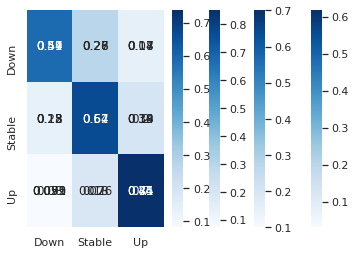

In [12]:
for days_training in [1,2,4,7]:
    print('Days Training now ', days_training)
    X_train_val, y_train_val, X_test, y_test = generate_data(l2_snap, 40, columns = ['b1','b2','b3','b4','b5','b6','b7','b8', 'b9', 'b10', 'a1','a2','a3','a4','a5','a6','a7','a8', 'a9', 'a10', 'bq1','bq2','bq3','bq4','bq5','bq6','bq7','bq8', 'bq9', 'bq10', 'aq1','aq2','aq3','aq4','aq5','aq6','aq7','aq8', 'aq9', 'aq10'], days_training=days_training)
    m = generate_model(40)
    from sklearn.utils.class_weight import compute_class_weight
    class_weights = compute_class_weight('balanced', np.unique(y_train_val), y_train_val)
    d_class_weights = dict(enumerate(class_weights))

    EPOCHS = 20
    model_filename = "model_resnet_walkforward_tcn_depth10.h5"
    hist_filename = "hist_model_walkforward_tcn_depth10.csv"
    early_stop = keras.callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=4)
    model_save_checkpoint = keras.callbacks.ModelCheckpoint(
                                filepath= model_filename,
                                save_best_only=True,
                                monitor='val_loss',
                                verbose=1)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
                    monitor='val_loss',
                    factor=0.5,
                    patience=2,
                    verbose=1,
                    min_lr=0.0001)
    callbacks = [reduce_lr, model_save_checkpoint, early_stop]
    history = m.fit(
                X_train_val, y_train_val,
                epochs=EPOCHS,
                batch_size=128,
                callbacks=callbacks,
                class_weight = d_class_weights,
                validation_data = (X_test, y_test),
    )

    y_pred = m.predict(X_test).argmax(axis=1)

    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set()
    cm = confusion_matrix(y_pred=y_pred, y_true=y_test)

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    ax=sns.heatmap(cm, annot=True, xticklabels=['Down','Stable','Up'], yticklabels=['Down','Stable','Up'], cmap='Blues')
    ax.set_ylim(3.0, 0)
    plt.savefig('image_depth_10_{}_days_training'.format(days_training))

    from sklearn.metrics import classification_report
    print(classification_report(y_true = y_test,y_pred = y_pred,  target_names=['Down', 'Stable', 'Up']))

Text(0.5, 0, 'Days used for training')

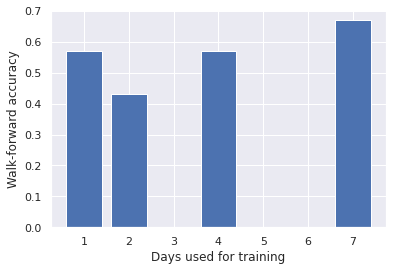

In [17]:
plt.bar([1,2,4,7], [0.57, 0.43, 0.57, 0.67])
plt.ylabel('Walk-forward accuracy')
plt.xlabel('Days used for training')

## Depth 5

In [ ]:
# X_train_val, y_train_val, X_test, y_test = generate_data(l2_snap, 20, columns = ['b1','b2','b3','b4','b5', 'a1','a2','a3','a4','a5', 'bq1','bq2','bq3','bq4','bq5', 'aq1','aq2','aq3','aq4','aq5'] )

In [ ]:
# m = generate_model(20)
# from sklearn.utils.class_weight import compute_class_weight
# class_weights = compute_class_weight('balanced', np.unique(y_train_val), y_train_val)
# d_class_weights = dict(enumerate(class_weights))

In [ ]:
# EPOCHS = 20
# model_filename = "model_resnet_walkforward_tcn_depth5.h5"
# hist_filename = "hist_model_walkforward_tcn_depth5.csv"
# early_stop = keras.callbacks.EarlyStopping(
#                 monitor='val_loss',
#                 patience=4)
# model_save_checkpoint = keras.callbacks.ModelCheckpoint(
#                             filepath= model_filename,
#                             save_best_only=True,
#                             monitor='val_loss',
#                             verbose=1)
# reduce_lr = keras.callbacks.ReduceLROnPlateau(
#                 monitor='val_loss',
#                 factor=0.5,
#                 patience=2,
#                 verbose=1,
#                 min_lr=0.0001)
# callbacks = [reduce_lr, model_save_checkpoint, early_stop]
# history = m.fit(
#             X_train_val, y_train_val,
#             epochs=EPOCHS,
#             batch_size=128,
#             callbacks=callbacks,
#             class_weight = d_class_weights,
#             validation_data = (X_test, y_test),
# )

In [ ]:
# y_pred = m.predict(X_test).argmax(axis=1)

In [ ]:
# from sklearn.metrics import confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set()
# cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
    
# cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# ax=sns.heatmap(cm, annot=True, xticklabels=['Down','Stable','Up'], yticklabels=['Down','Stable','Up'], cmap='Blues')
# ax.set_ylim(3.0, 0)
# plt.savefig('image_depth_5')

In [ ]:
# from sklearn.metrics import classification_report
# print(classification_report(y_true = y_test,y_pred = y_pred,  target_names=['Down', 'Stable', 'Up']))

## DEPTH 1

In [ ]:
# X_train_val, y_train_val, X_test, y_test = generate_data(l2_snap, 4, columns=['b1','a1','bq1','aq1'])

In [ ]:
# m = generate_model(4)

In [ ]:
# from sklearn.utils.class_weight import compute_class_weight
# class_weights = compute_class_weight('balanced', np.unique(y_train_val), y_train_val)
# d_class_weights = dict(enumerate(class_weights))

In [ ]:
# EPOCHS = 20
# model_filename = "model_resnet_walkforward_tcn.h5"
# hist_filename = "hist_model_walkforward_tcn.csv"
# early_stop = keras.callbacks.EarlyStopping(
#                 monitor='val_loss',
#                 patience=4)
# model_save_checkpoint = keras.callbacks.ModelCheckpoint(
#                             filepath= model_filename,
#                             save_best_only=True,
#                             monitor='val_loss',
#                             verbose=1)
# reduce_lr = keras.callbacks.ReduceLROnPlateau(
#                 monitor='val_loss',
#                 factor=0.5,
#                 patience=2,
#                 verbose=1,
#                 min_lr=0.0001)
# callbacks = [reduce_lr, model_save_checkpoint, early_stop]
# history = m.fit(
#             X_train_val, y_train_val,
#             epochs=EPOCHS,
#             batch_size=128,
#             callbacks=callbacks,
#             class_weight = d_class_weights,
#             validation_data = (X_test, y_test),
# )

In [ ]:
# y_pred = m.predict(X_test).argmax(axis=1)

In [ ]:
# from sklearn.metrics import confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set()
# cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
    
# cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# ax=sns.heatmap(cm, annot=True, xticklabels=['Down','Stable','Up'], yticklabels=['Down','Stable','Up'], cmap='Blues')
# ax.set_ylim(3.0, 0)
# plt.savefig('image_depth_2')

In [ ]:
# from sklearn.metrics import classification_report
# print(classification_report(y_true = y_test,y_pred = y_pred,  target_names=['Down', 'Stable', 'Up']))